In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder

In [2]:
pd.options.display.max_columns = None

In [3]:
data = pd.read_csv("data.csv")

In [4]:
# column name change
data.columns = data.columns.str.replace("-","_")

# data.rename({'glyburide-metformin':'glyburide_metformin', 'glipizide-metformin':'glipizide_metformin','glimepiride-pioglitazone':'glimepiride_pioglitazone','metformin-rosiglitazone':'metformin_rosiglitazone', 'metformin-pioglitazone': 'metformin_pioglitazone'}, axis =1, inplace = True)

In [5]:
# duplicate patient_nbr - remove
data.drop_duplicates(['patient_nbr'], inplace = True, ignore_index = True)

In [6]:
# Remove discharge_disposition_id : unique value '13','14','19','20','21' 
is_drop = [item in [13,14,19,20,21] for item in data.discharge_disposition_id]
drop_row_index = [ i for i, is_drop_item in enumerate(is_drop) if is_drop_item]
data.drop(drop_row_index, inplace = True)

In [7]:
# value imputation ==> "?" =? Nan
object_col = data.loc[:,list(data.dtypes == 'object')].columns
for col in object_col:
    data[col] = data[col].str.replace('?', 'Nan')

In [8]:
data.shape

(71050, 50)

### Features description

- admission type(9 distinct value) :  emrgency, urgent, elective, newborn, and not available
- Discharge disposition (29 distinct values) : discharged to home, expired, and not available
- Admission source ( 21 distinct values ) : physician referral, emergency room, and transfer from a hospital
- Time in hospital : number of days between admission and discharge
- Payer code( 23 distinct values ) : Blue Cross/Blue Shield, Medicare, and self-pay
- Medical specialty Integer identifier of a specialty of the admitting physician( 84 distinct values) : cardiology, internal medicine, family/general practice, and surgeon
- num_lab_procedures : Number of lab tests performed during the encounter
- Number of procedures(other than lab tests) performed during the encounter
- Number of medications : - Number of distinct generic names administered during the encounter
- number_outpatient, number_emergency, number_inpatient : visit number
- diag_1	diag_2	diag_3 : The primary, secondary, additional secondary diagnosis
- Number of diagnoses : Number of diagnoses entered to the system
- Glucose serum test result (Indicates the range of the result or if the test was not taken) :“>200,” “>300,” “normal,” and “none” if not measured
- A1c test result : Indicates the range of the result or if the test was not taken : “>8” if the result was greater than 8%, “>7” if the result was greater than 7% but less than 8%, “normal” if the result was less than 7%, and “none” if not measured.

#### value_code
- 9 admission type 
- 29 Discharge disposition
- 21 Admission source 
- 23 Payer code

## Mediacton features

24 kinds of medications
- the amount of dosage is changed : up, down, steady
- if the drug was not prescribed : no

In [9]:
data.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide_metformin', 'glipizide_metformin',
       'glimepiride_pioglitazone', 'metformin_rosiglitazone',
       'metformin_pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [10]:
medication_features = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide_metformin', 'glipizide_metformin',
       'glimepiride_pioglitazone', 'metformin_rosiglitazone',
       'metformin_pioglitazone','readmitted']

In [11]:
df_medication = data[medication_features]
a_med = df_medication.apply(pd.Series.value_counts)
a_med

,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,readmitted
<30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6277.0
>30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22222.0
Down,435.0,28.0,8.0,1.0,136.0,NaN,374.0,420.0,NaN,81.0,74.0,NaN,1.0,NaN,NaN,NaN,NaN,7455.0,4.0,NaN,NaN,NaN,NaN,NaN
NO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42551.0
No,56092.0,70129.0,70554.0,70978.0,67321.0,71049.0,61988.0,63230.0,71031.0,65760.0,66365.0,70849.0,71030.0,71047.0,71020.0,71050.0,71050.0,34715.0,70548.0,71043.0,71050.0,71048.0,71049.0,NaN
Steady,13689.0,822.0,472.0,67.0,3360.0,1.0,8112.0,6783.0,19.0,5029.0,4476.0,191.0,18.0,3.0,30.0,NaN,NaN,21967.0,491.0,7.0,NaN,2.0,1.0,NaN
Up,834.0,71.0,16.0,4.0,233.0,NaN,576.0,617.0,NaN,180.0,135.0,10.0,1.0,NaN,NaN,NaN,NaN,6913.0,7.0,NaN,NaN,NaN,NaN,NaN


In [12]:
# target variable : readmitted 
#  “<30” : less than 30 days, “>30” :  more than 30 days, and “No” for no record of readmission
data.readmitted.unique()

array(['NO', '>30', '<30'], dtype=object)

In [13]:
readmit_dict = {'NO' : 0, '>30' : 0, '<30' : 1}
data.readmitted.replace(readmit_dict, inplace = True)

Text(0.5, 1.0, ' readmitted patients within 30 days')

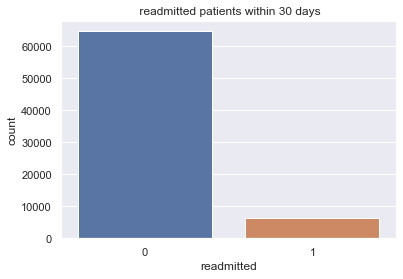

In [14]:
# readmitted ratio in 30 days : 9%
target = data.readmitted.value_counts()

# sns.barplot(x=target.index, y=data.readmitted.value_counts())
sns.set(rc={'figure.figsize':(6, 4)})
sns.countplot(x=data.readmitted, data=data).set_title(' readmitted patients within 30 days')

In [15]:
data.readmitted.value_counts()

0    64773
1     6277
Name: readmitted, dtype: int64

In [16]:
target / target.sum() *100

0    91.165376
1     8.834624
Name: readmitted, dtype: float64

In [17]:
# Indicates if there was any diabetic medication prescribed. Values: “yes” and “no” ==> 80% "No"
data.metformin.value_counts()
metformin_pl = pd.DataFrame(data.metformin.value_counts()/sum(data.metformin.value_counts())*100)
metformin_pl

,metformin
No,78.947220
Steady,19.266714
Up,1.173821
Down,0.612245


In [232]:
data.metformin.value_counts()
metformin = pd.DataFrame(data.metformin.value_counts())
metformin


,metformin
No,56092
Steady,13689
Up,834
Down,435


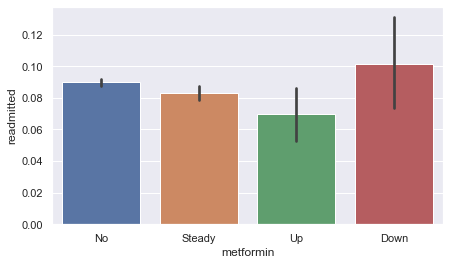

In [18]:
sns.set(rc={'figure.figsize':(7, 4)})
sns.barplot(data = data, x = 'metformin', y = 'readmitted')

In [19]:
data.groupby('metformin').readmitted.count()

metformin
Down        435
No        56092
Steady    13689
Up          834
Name: readmitted, dtype: int64

In [20]:
data.groupby('readmitted').insulin.count()

readmitted
0    64773
1     6277
Name: insulin, dtype: int64

In [23]:
data[(data.metformin == 'No') & (data.readmitted == 0)].metformin.count()

51052

In [24]:
data[(data.metformin == 'No') & (data.readmitted == 1)].metformin.value_counts()

No    5040
Name: metformin, dtype: int64

In [25]:
metformin = data[data.metformin == "No"]
pd.DataFrame(metformin.readmitted.value_counts())

,readmitted
0,51052
1,5040


Text(0.5, 1.0, 'readmitted patients number without metformin medication')

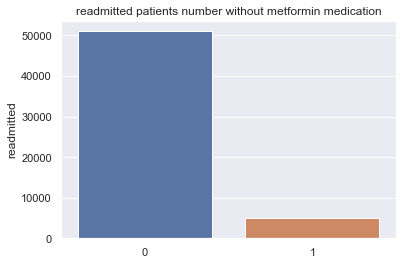

In [26]:
metformin = data[data.metformin == "No"]
a = metformin.readmitted.value_counts()
sns.set(rc={'figure.figsize':(6, 4)})
sns.barplot(x=a.index, y=a).set_title('readmitted patients number without metformin medication')

In [27]:
metformin = data[data.metformin != "No"]
# metformin.readmitted.value_counts()/len(metformin)*100
pd.DataFrame(metformin.readmitted.value_counts())

,readmitted
0,13721
1,1237


Text(0.5, 1.0, 'readmitted patients number without metformin medication')

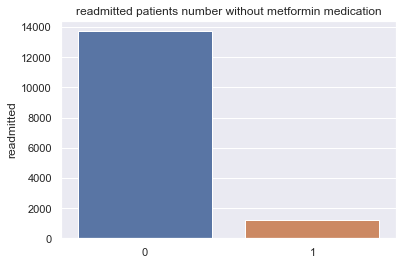

In [28]:
metformin = data[data.metformin != "No"]
a = metformin.readmitted.value_counts()
sns.set(rc={'figure.figsize':(6, 4)})
sns.barplot(x=a.index, y=a).set_title('readmitted patients number without metformin medication')

In [19]:
data.repaglinide.value_counts()
repaglinide = pd.DataFrame(data.repaglinide.value_counts()/sum(data.repaglinide.value_counts())*100)
repaglinide

,repaglinide
No,98.703730
Steady,1.156932
Up,0.099930
Down,0.039409


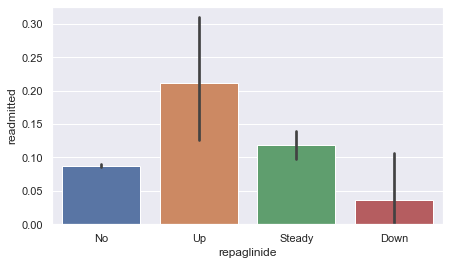

In [29]:
sns.set(rc={'figure.figsize':(7, 4)})
sns.barplot(data = data, x = 'repaglinide', y = 'readmitted')

In [20]:
repaglinide = data[data.repaglinide == "No"]
repaglinide.readmitted.value_counts()/len(repaglinide)*100

0    91.211909
1     8.788091
Name: readmitted, dtype: float64

Text(0.5, 1.0, 'readmitted patients number with repaglinide medication')

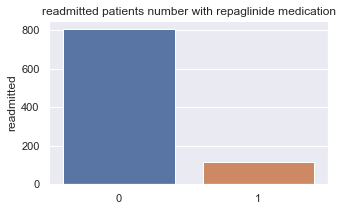

In [31]:
repaglinide = data[data.repaglinide != "No"]
a = repaglinide.readmitted.value_counts()
sns.barplot(x=a.index, y=a)
sns.set(rc={'figure.figsize':(5, 3)})
sns.barplot(x=a.index, y=a).set_title('readmitted patients number with repaglinide medication')

Text(0.5, 1.0, 'readmitted patients number with repaglinide medication')

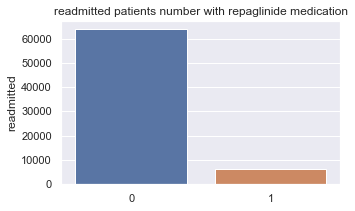

In [32]:
repaglinide = data[data.repaglinide == "No"]
a = repaglinide.readmitted.value_counts()
sns.barplot(x=a.index, y=a)
sns.set(rc={'figure.figsize':(5, 3)})
sns.barplot(x=a.index, y=a).set_title('readmitted patients number with repaglinide medication')

In [21]:
repaglinide = data[data.repaglinide != "No"]
repaglinide.readmitted.value_counts()/len(repaglinide)*100

0    87.62215
1    12.37785
Name: readmitted, dtype: float64

In [45]:
data.nateglinide.value_counts()
nateglinide = pd.DataFrame(data.nateglinide.value_counts())
nateglinide

,nateglinide
No,70554
Steady,472
Up,16
Down,8


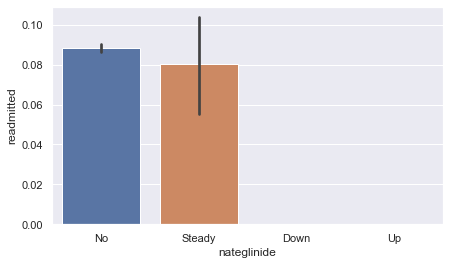

In [35]:
sns.set(rc={'figure.figsize':(7, 4)})
sns.barplot(data = data, x = 'nateglinide', y = 'readmitted')

In [23]:
nateglinide = data[data.nateglinide == "No"]
nateglinide.readmitted.value_counts()/len(nateglinide)*100

0    91.157128
1     8.842872
Name: readmitted, dtype: float64

In [24]:
nateglinide = data[data.nateglinide != "No"]
nateglinide.readmitted.value_counts()/len(nateglinide)*100

0    92.33871
1     7.66129
Name: readmitted, dtype: float64

In [36]:
data.chlorpropamide.value_counts()
chlorpropamide = pd.DataFrame(data.chlorpropamide.value_counts()/sum(data.chlorpropamide.value_counts())*100)
chlorpropamide

,chlorpropamide
No,99.898663
Steady,0.094300
Up,0.005630
Down,0.001407


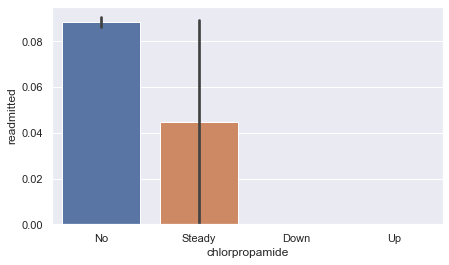

In [37]:
sns.set(rc={'figure.figsize':(7, 4)})
sns.barplot(data = data, x = 'chlorpropamide', y = 'readmitted')

In [26]:
chlorpropamide = data[data.chlorpropamide == "No"]
chlorpropamide.readmitted.value_counts()/len(chlorpropamide)*100

0    91.160641
1     8.839359
Name: readmitted, dtype: float64

In [27]:
chlorpropamide = data[data.chlorpropamide != "No"]
chlorpropamide.readmitted.value_counts()/len(chlorpropamide)*100

0    95.833333
1     4.166667
Name: readmitted, dtype: float64

In [47]:
data.glimepiride.value_counts()
glimepiride = pd.DataFrame(data.glimepiride.value_counts())
glimepiride

,glimepiride
No,67321
Steady,3360
Up,233
Down,136


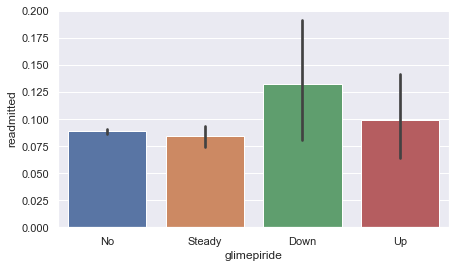

In [46]:
sns.set(rc={'figure.figsize':(7, 4)})
sns.barplot(data = data, x = 'glimepiride', y = 'readmitted')

In [29]:
glimepiride = data[data.glimepiride == "No"]
glimepiride.readmitted.value_counts()/len(glimepiride)*100

0    91.157291
1     8.842709
Name: readmitted, dtype: float64

In [30]:
glimepiride = data[data.glimepiride != "No"]
glimepiride.readmitted.value_counts()/len(glimepiride)*100

0    91.311344
1     8.688656
Name: readmitted, dtype: float64

In [49]:
data.acetohexamide.value_counts()
acetohexamide = pd.DataFrame(data.acetohexamide.value_counts())
acetohexamide

,acetohexamide
No,71049
Steady,1


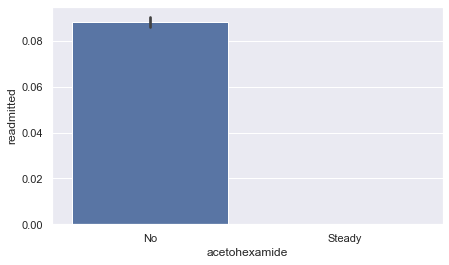

In [48]:
sns.set(rc={'figure.figsize':(7, 4)})
sns.barplot(data = data, x = 'acetohexamide', y = 'readmitted')

In [32]:
acetohexamide = data[data.acetohexamide == "No"]
acetohexamide.readmitted.value_counts()/len(acetohexamide)*100

0    91.165252
1     8.834748
Name: readmitted, dtype: float64

In [33]:
acetohexamide = data[data.acetohexamide != "No"]
acetohexamide.readmitted.value_counts()/len(acetohexamide)*100

0    100.0
Name: readmitted, dtype: float64

In [51]:
data.glipizide.value_counts()
glipizide = pd.DataFrame(data.glipizide.value_counts())
glipizide

,glipizide
No,61988
Steady,8112
Up,576
Down,374


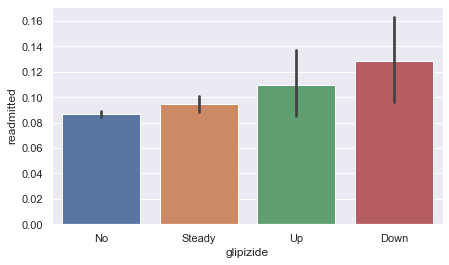

In [50]:
sns.set(rc={'figure.figsize':(7, 4)})
sns.barplot(data = data, x = 'glipizide', y = 'readmitted')

In [35]:
glipizide = data[data.glipizide == "No"]
glipizide.readmitted.value_counts()/len(glipizide)*100


0    91.288637
1     8.711363
Name: readmitted, dtype: float64

In [36]:
glipizide = data[data.glipizide != "No"]
glipizide.readmitted.value_counts()/len(glipizide)*100

0    90.322225
1     9.677775
Name: readmitted, dtype: float64

In [54]:
data.glyburide.value_counts()
glyburide = pd.DataFrame(data.glyburide.value_counts())
glyburide

,glyburide
No,63230
Steady,6783
Up,617
Down,420


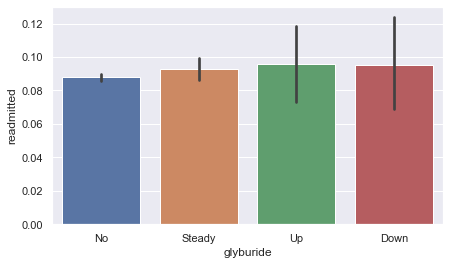

In [52]:
sns.set(rc={'figure.figsize':(7, 4)})
sns.barplot(data = data, x = 'glyburide', y = 'readmitted')

In [38]:
glyburide = data[data.glyburide == "No"]
glyburide.readmitted.value_counts()/len(glyburide)*100

0    91.225684
1     8.774316
Name: readmitted, dtype: float64

In [39]:
glyburide = data[data.glyburide != "No"]
glyburide.readmitted.value_counts()/len(glyburide)*100

0    90.677749
1     9.322251
Name: readmitted, dtype: float64

In [56]:
data.tolbutamide.value_counts()
tolbutamide = pd.DataFrame(data.tolbutamide.value_counts())
tolbutamide

,tolbutamide
No,71031
Steady,19


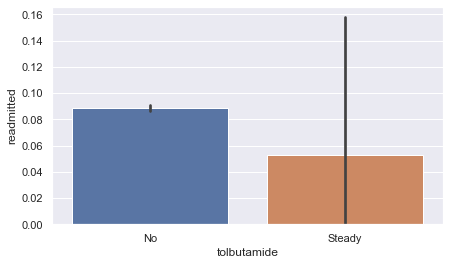

In [57]:
sns.set(rc={'figure.figsize':(7, 4)})
sns.barplot(data = data, x = 'tolbutamide', y = 'readmitted')

In [41]:
tolbutamide = data[data.tolbutamide == "No"]
tolbutamide.readmitted.value_counts()/len(tolbutamide)*100

0    91.164421
1     8.835579
Name: readmitted, dtype: float64

In [42]:
tolbutamide = data[data.tolbutamide != "No"]
tolbutamide.readmitted.value_counts()/len(tolbutamide)*100

0    94.736842
1     5.263158
Name: readmitted, dtype: float64

In [59]:
data.pioglitazone.value_counts()
pioglitazone = pd.DataFrame(data.pioglitazone.value_counts())
pioglitazone

,pioglitazone
No,65760
Steady,5029
Up,180
Down,81


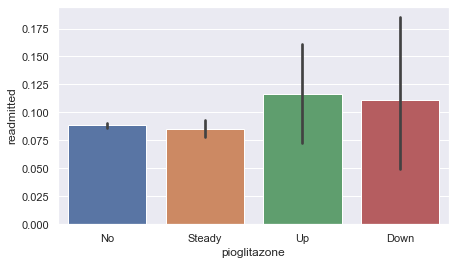

In [58]:
sns.set(rc={'figure.figsize':(7, 4)})
sns.barplot(data = data, x = 'pioglitazone', y = 'readmitted')

In [44]:
pioglitazone = data[data.pioglitazone == "No"]
pioglitazone.readmitted.value_counts()/len(pioglitazone)*100

0    91.152676
1     8.847324
Name: readmitted, dtype: float64

In [45]:
pioglitazone = data[data.pioglitazone != "No"]
pioglitazone.readmitted.value_counts()/len(pioglitazone)*100

0    91.323251
1     8.676749
Name: readmitted, dtype: float64

In [61]:
data.rosiglitazone.value_counts()
rosiglitazone = pd.DataFrame(data.rosiglitazone.value_counts())
rosiglitazone

,rosiglitazone
No,66365
Steady,4476
Up,135
Down,74


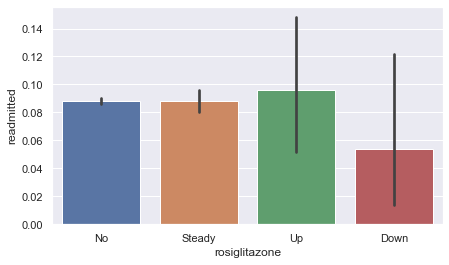

In [60]:
sns.set(rc={'figure.figsize':(7, 4)})
sns.barplot(data = data, x = 'rosiglitazone', y = 'readmitted')

In [47]:
rosiglitazone = data[data.rosiglitazone == "No"]
rosiglitazone.readmitted.value_counts()/len(rosiglitazone)*100

0    91.159497
1     8.840503
Name: readmitted, dtype: float64

In [48]:
rosiglitazone = data[data.rosiglitazone != "No"]
rosiglitazone.readmitted.value_counts()/len(rosiglitazone)*100

0    91.248666
1     8.751334
Name: readmitted, dtype: float64

In [49]:
data.acarbose.value_counts()
acarbose = pd.DataFrame(data.acarbose.value_counts()/sum(data.acarbose.value_counts())*100)
acarbose

,acarbose
No,99.717101
Steady,0.268825
Up,0.014075


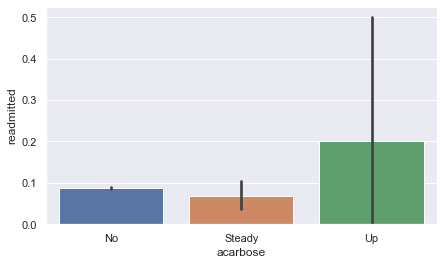

In [62]:
sns.set(rc={'figure.figsize':(7, 4)})
sns.barplot(data = data, x = 'acarbose', y = 'readmitted')

In [50]:
acarbose = data[data.acarbose == "No"]
acarbose.readmitted.value_counts()/len(acarbose)*100

0    91.161484
1     8.838516
Name: readmitted, dtype: float64

In [51]:
acarbose = data[data.acarbose != "No"]
acarbose.readmitted.value_counts()/len(acarbose)*100

0    92.537313
1     7.462687
Name: readmitted, dtype: float64

In [63]:
data.miglitol.value_counts()
miglitol = pd.DataFrame(data.miglitol.value_counts())
miglitol

,miglitol
No,71030
Steady,18
Down,1
Up,1


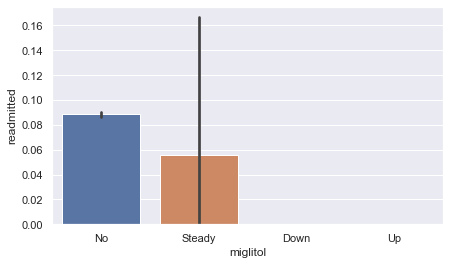

In [64]:
sns.set(rc={'figure.figsize':(7, 4)})
sns.barplot(data = data, x = 'miglitol', y = 'readmitted')

In [53]:
miglitol = data[data.miglitol == "No"]
miglitol.readmitted.value_counts()/len(miglitol)*100

0    91.164297
1     8.835703
Name: readmitted, dtype: float64

In [54]:
miglitol = data[data.miglitol != "No"]
miglitol.readmitted.value_counts()/len(miglitol)*100

0    95.0
1     5.0
Name: readmitted, dtype: float64

In [67]:
data.troglitazone.value_counts()
troglitazone = pd.DataFrame(data.troglitazone.value_counts())
troglitazone

,troglitazone
No,71047
Steady,3


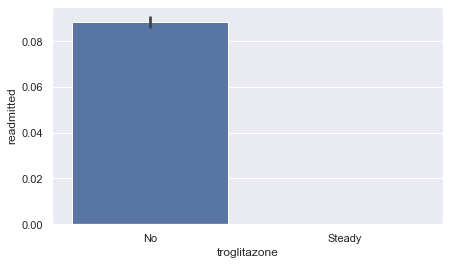

In [65]:
sns.set(rc={'figure.figsize':(7, 4)})
sns.barplot(data = data, x = 'troglitazone', y = 'readmitted')

In [56]:
troglitazone = data[data.troglitazone == "No"]
troglitazone.readmitted.value_counts()/len(troglitazone)*100

0    91.165003
1     8.834997
Name: readmitted, dtype: float64

In [57]:
troglitazone = data[data.troglitazone != "No"]
troglitazone.readmitted.value_counts()/len(troglitazone)*100

0    100.0
Name: readmitted, dtype: float64

In [69]:
data.tolazamide.value_counts()
tolazamide = pd.DataFrame(data.tolazamide.value_counts())
tolazamide

,tolazamide
No,71020
Steady,30


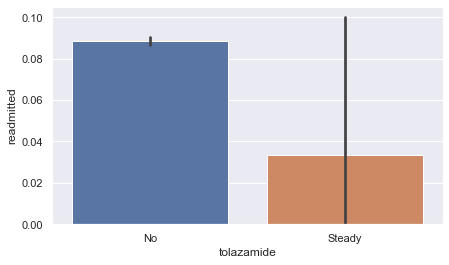

In [68]:
sns.set(rc={'figure.figsize':(7, 4)})
sns.barplot(data = data, x = 'tolazamide', y = 'readmitted')

In [59]:
tolazamide = data[data.tolazamide == "No"]
tolazamide.readmitted.value_counts()/len(tolazamide)*100

0    91.163053
1     8.836947
Name: readmitted, dtype: float64

In [60]:
tolazamide = data[data.tolazamide != "No"]
tolazamide.readmitted.value_counts()/len(tolazamide)*100

0    96.666667
1     3.333333
Name: readmitted, dtype: float64

In [71]:
data.examide.value_counts()
examide = pd.DataFrame(data.examide.value_counts())
examide

,examide
No,71050


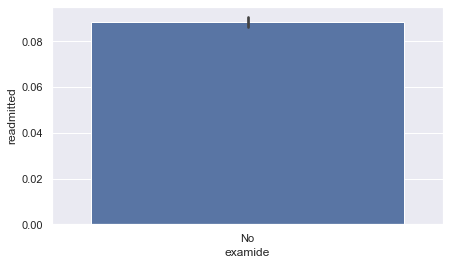

In [70]:
sns.set(rc={'figure.figsize':(7, 4)})
sns.barplot(data = data, x = 'examide', y = 'readmitted')

In [62]:
examide = data[data.examide == "No"]
examide.readmitted.value_counts()/len(examide)*100

0    91.165376
1     8.834624
Name: readmitted, dtype: float64

In [73]:
data.citoglipton.value_counts()
citoglipton = pd.DataFrame(data.citoglipton.value_counts())
citoglipton

,citoglipton
No,71050


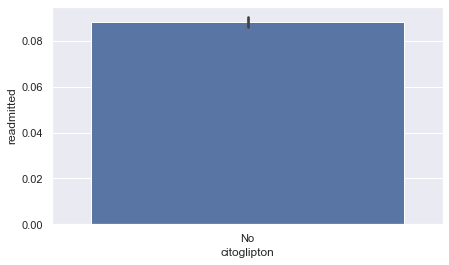

In [72]:
sns.set(rc={'figure.figsize':(7, 4)})
sns.barplot(data = data, x = 'citoglipton', y = 'readmitted')

In [64]:
citoglipton = data[data.citoglipton == "No"]
citoglipton.readmitted.value_counts()/len(citoglipton)*100

0    91.165376
1     8.834624
Name: readmitted, dtype: float64

In [65]:
data.insulin.value_counts()
insulin = pd.DataFrame(data.insulin.value_counts()/sum(data.insulin.value_counts())*100)
insulin

,insulin
No,48.859958
Steady,30.917664
Down,10.492611
Up,9.729768


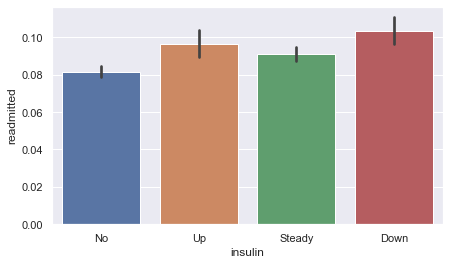

In [74]:
sns.set(rc={'figure.figsize':(7, 4)})
sns.barplot(data = data, x = 'insulin', y = 'readmitted')

In [66]:
insulin = data[data.insulin == "No"]
insulin.readmitted.value_counts()/len(insulin)*100

0    91.82774
1     8.17226
Name: readmitted, dtype: float64

In [67]:
insulin = data[data.insulin != "No"]
insulin.readmitted.value_counts()/len(insulin)*100

0    90.532544
1     9.467456
Name: readmitted, dtype: float64

In [68]:
data.glyburide_metformin.value_counts()
glyburide_metformin = pd.DataFrame(data.glyburide_metformin.value_counts()/sum(data.glyburide_metformin.value_counts())*100)
glyburide_metformin

,glyburide_metformin
No,99.293455
Steady,0.691063
Up,0.009852
Down,0.005630


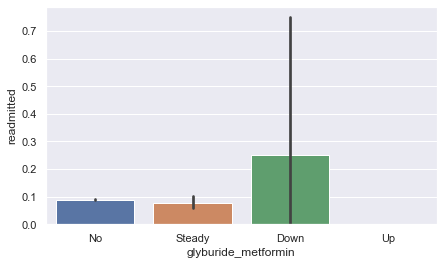

In [75]:
sns.set(rc={'figure.figsize':(7, 4)})
sns.barplot(data = data, x = 'glyburide_metformin', y = 'readmitted')

In [69]:
glyburide_metformin = data[data.glyburide_metformin == "No"]
glyburide_metformin.readmitted.value_counts()/len(glyburide_metformin)*100

0    91.157793
1     8.842207
Name: readmitted, dtype: float64

In [70]:
glyburide_metformin = data[data.glyburide_metformin != "No"]
glyburide_metformin.readmitted.value_counts()/len(glyburide_metformin)*100

0    92.231076
1     7.768924
Name: readmitted, dtype: float64

In [77]:
data.glipizide_metformin.value_counts()
glipizide_metformin = pd.DataFrame(data.glipizide_metformin.value_counts())
glipizide_metformin

,glipizide_metformin
No,71043
Steady,7


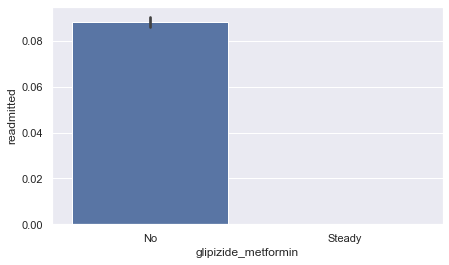

In [78]:
sns.set(rc={'figure.figsize':(7, 4)})
sns.barplot(data = data, x = 'glipizide_metformin', y = 'readmitted')

In [72]:
glipizide_metformin = data[data.glipizide_metformin == "No"]
glipizide_metformin.readmitted.value_counts()/len(glipizide_metformin)*100

0    91.164506
1     8.835494
Name: readmitted, dtype: float64

In [73]:
glipizide_metformin = data[data.glipizide_metformin != "No"]
glipizide_metformin.readmitted.value_counts()/len(glipizide_metformin)*100

0    100.0
Name: readmitted, dtype: float64

In [80]:
data.glimepiride_pioglitazone.value_counts()
glimepiride_pioglitazone = pd.DataFrame(data.glimepiride_pioglitazone.value_counts())
glimepiride_pioglitazone

,glimepiride_pioglitazone
No,71050


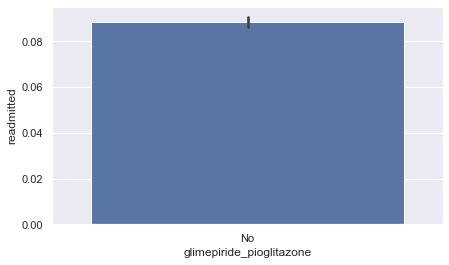

In [79]:
sns.set(rc={'figure.figsize':(7, 4)})
sns.barplot(data = data, x = 'glimepiride_pioglitazone', y = 'readmitted')

In [75]:
glimepiride_pioglitazone = data[data.metformin_rosiglitazone == "No"]
glimepiride_pioglitazone.readmitted.value_counts()/len(glimepiride_pioglitazone)*100

0    91.165128
1     8.834872
Name: readmitted, dtype: float64

In [82]:
data.metformin_rosiglitazone.value_counts()
metformin_rosiglitazone = pd.DataFrame(data.metformin_rosiglitazone.value_counts())
metformin_rosiglitazone

,metformin_rosiglitazone
No,71048
Steady,2


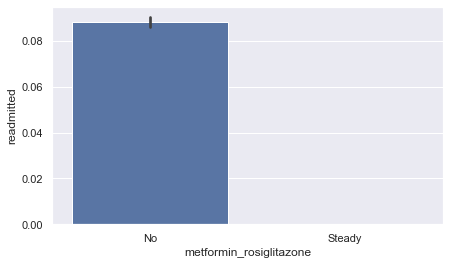

In [81]:
sns.set(rc={'figure.figsize':(7, 4)})
sns.barplot(data = data, x = 'metformin_rosiglitazone', y = 'readmitted')

In [77]:
# patient ratio in metformin_rosiglitazone == "No"
metformin_rosiglitazone = data[data.metformin_rosiglitazone == "No"]
metformin_rosiglitazone.readmitted.value_counts()/len(metformin_rosiglitazone)*100

0    91.165128
1     8.834872
Name: readmitted, dtype: float64

In [78]:
metformin_rosiglitazone = data[data.metformin_rosiglitazone != "No"]
metformin_rosiglitazone.readmitted.value_counts()/len(metformin_rosiglitazone)*100

0    100.0
Name: readmitted, dtype: float64

In [79]:
data.metformin_pioglitazone.value_counts()
metformin_pioglitazone = pd.DataFrame(data.metformin_pioglitazone.value_counts()/sum(data.metformin_pioglitazone.value_counts())*100)
metformin_pioglitazone

,metformin_pioglitazone
No,99.998593
Steady,0.001407


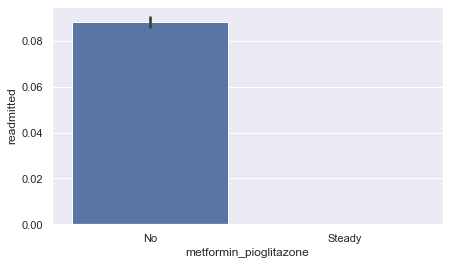

In [83]:
sns.set(rc={'figure.figsize':(7, 4)})
sns.barplot(data = data, x = 'metformin_pioglitazone', y = 'readmitted')

In [81]:
# patient ratio in metformin_pioglita == "No"
metformin_pioglitazone = data[data.metformin_pioglitazone == "No"]
metformin_pioglitazone.readmitted.value_counts()/len(metformin_pioglitazone)*100

0    91.165252
1     8.834748
Name: readmitted, dtype: float64

In [82]:
metformin_pioglitazone = data[data.metformin_pioglitazone != "No"]
metformin_pioglitazone.readmitted.value_counts()/len(metformin_pioglitazone)*100

0    100.0
Name: readmitted, dtype: float64

In [83]:
c = data.change.value_counts()
# change = pd.DataFrame(data.change.value_counts()/sum(data.change.value_counts())*100)
change = pd.DataFrame(data.change.value_counts())
change

,change
No,39201
Ch,31849


Text(0.5, 1.0, 'Percent of patients readmitted by medication change')

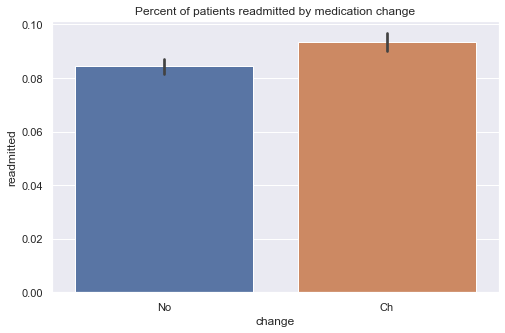

In [182]:
sns.set(rc={'figure.figsize':(8, 5)})
sns.barplot(data = data,
            x = 'change', y = 'readmitted').\
set_title('Percent of patients readmitted by medication change')

In [112]:
data.change.value_counts()
change = pd.DataFrame(data.change.value_counts())
change

,change
No,39201
Ch,31849


Text(0.5, 1.0, ' patients readmitted by change medication')

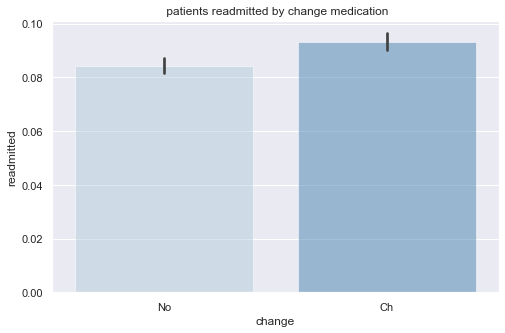

In [201]:
sns.set(rc={'figure.figsize':(8, 5)})
sns.barplot(data = data,
            x = 'change', y = 'readmitted',palette="Blues", alpha = 0.5 ).\
set_title(' patients readmitted by change medication')

Text(0.5, 1.0, 'readmitted patients number within 30 days by medication change')

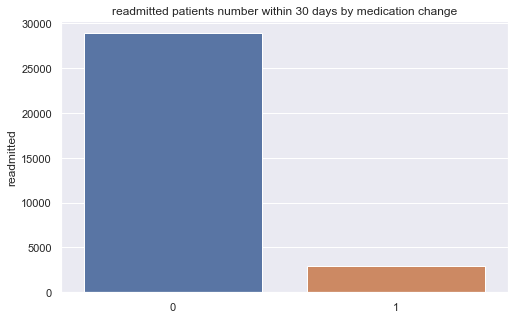

In [325]:
change1 = data[data.change != "No"]
g = change1.readmitted.value_counts()
sns.set(rc={'figure.figsize':(8, 5)})
sns.barplot(x=g.index, y=g).set_title('readmitted patients number within 30 days by medication change')

In [327]:
pd.DataFrame(change1.readmitted.value_counts())

,readmitted
0,28878
1,2971


In [ ]:
c.plot.pie()

In [ ]:
# Indicates if there was any diabetic medication prescribed. Values: “yes” and “no”
data.diabetesMed.value_counts()
diabetesMed = pd.DataFrame(data.diabetesMed.value_counts()/sum(data.diabetesMed.value_counts())*100)
diabetesMed

In [330]:
pd.DataFrame(data.diabetesMed.value_counts())


,diabetesMed
Yes,54001
No,17049


Text(0.5, 1.0, 'readmission percentage by diabetes Med')

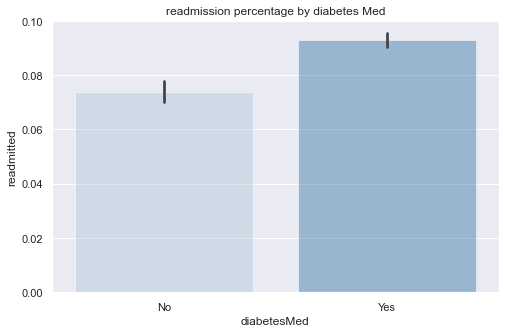

In [332]:
sns.set(rc={'figure.figsize':(8, 5)})
sns.barplot(data = data,
            x = 'diabetesMed', y = 'readmitted',palette="Blues", alpha = 0.5  ).\
set_title('readmission percentage by diabetes Med')

In [ ]:
data.

In [196]:
# patient ratio in diabetesMed == "Yes"
diabetesMed = data[data.diabetesMed == "Yes"]
diabetesMed.readmitted.value_counts()/len(diabetesMed)*100

0    90.707579
1     9.292421
Name: readmitted, dtype: float64

In [197]:
diabetesMed = data[data.diabetesMed != "Yes"]
diabetesMed.readmitted.value_counts()/len(diabetesMed)*100



0    92.615403
1     7.384597
Name: readmitted, dtype: float64

In [329]:
pd.DataFrame(diabetesMed.readmitted.value_counts())

,readmitted
0,48983
1,5018


Text(0.5, 1.0, 'readmitted patients number with diabetesMed')

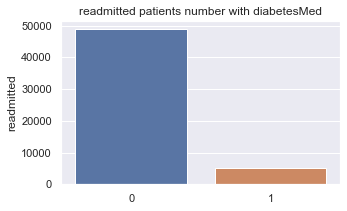

In [328]:
diabetesMed = data[data.diabetesMed != "No"]
a = diabetesMed.readmitted.value_counts()
sns.set(rc={'figure.figsize':(5, 3)})
sns.barplot(x=a.index, y=a).set_title('readmitted patients number with diabetesMed')